Code by Nitin Malik, India, https://www.linkedin.com/in/drnitinmalik/ dated 28 Nov 2021

Domain: Finance Credit Risk
Problem Statement: How to decide whether to approve loan or not?
Existing alternative: Loan Officer
Proposed Solution: Binary classifier to predict whether a loan application will be approved by Dream Housing Finance Company
Key metric: Accuracy
Target Customer: Banks and Financial Institutions
Purpose: To automate the loan eligibility process
Dataset source: https://www.kaggle.com/ninzaami/loan-predication/home

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
import seaborn as sns
import statistics
from sklearn import model_selection
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,plot_confusion_matrix, accuracy_score
import statsmodels.api as sm

In [2]:
train = pd.read_csv("train_ctrUa4K.csv")
print(train.shape)
train.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
# Meta Data
# Loan Amount: Loan Amount in thousands
# Loan_Amount_term: term of loan in months
# Credit_History: Credit history meets guidelines
# Loan Status: Loan approved (yes or No)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
test = pd.read_csv("test_lAUu6dG.csv")
print(test.shape)
test.head()

(367, 12)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [6]:
train_original=train.copy()
test_original=test.copy()

In [7]:
train.drop('Loan_ID', axis=1, inplace=True)
test.drop('Loan_ID', axis=1, inplace=True)

In [8]:
# checking for duplicate data
dups = train.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


## univariate analysis

In [9]:
# dependent variable: checking for class imbalance
train['Loan_Status'].value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

In [10]:
# independent variables

<AxesSubplot:title={'center':'Gender'}>

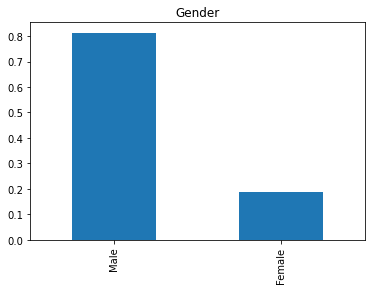

In [12]:
train['Gender'].value_counts(normalize=True).plot.bar(title='Gender')

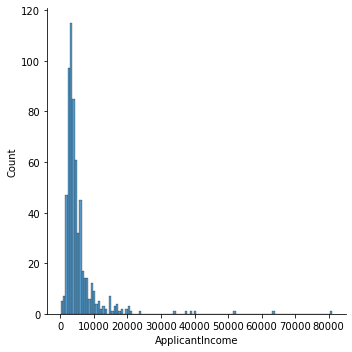

In [14]:
sns.displot(train['ApplicantIncome']);

<AxesSubplot:>

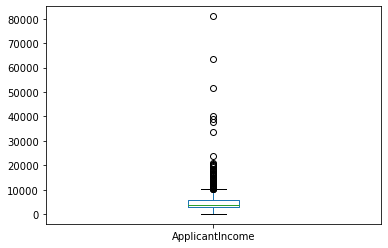

In [15]:
# checking for outliers in numerical independent variables
train['ApplicantIncome'].plot.box() # outliers in Income may be due to education level

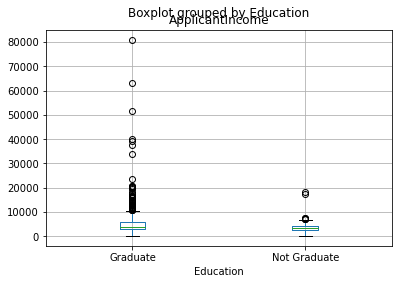

In [16]:
train.boxplot(column='ApplicantIncome', by='Education');

<AxesSubplot:>

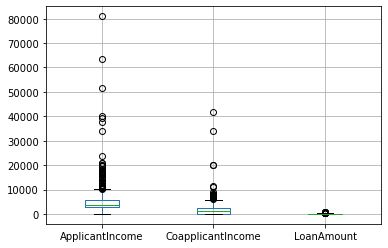

In [17]:
train.boxplot(column=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'])
# outliers in all

<AxesSubplot:>

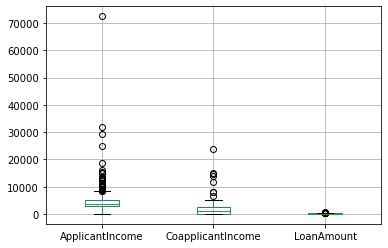

In [18]:
test.boxplot(column=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'])
# outliers in all

## preprocessing

In [19]:
# treating outliers by floor capping
def treat_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [20]:
lr,ur=treat_outlier(train['ApplicantIncome'])
train['ApplicantIncome']=np.where(train['ApplicantIncome']>ur,ur,train['ApplicantIncome'])
lr,ur=treat_outlier(train['CoapplicantIncome'])
train['CoapplicantIncome']=np.where(train['CoapplicantIncome']>ur,ur,train['CoapplicantIncome'])
lr,ur=treat_outlier(train['LoanAmount'])
train['LoanAmount']=np.where(train['LoanAmount']>ur,ur,train['LoanAmount'])

In [21]:
lr,ur=treat_outlier(test['ApplicantIncome'])
test['ApplicantIncome']=np.where(test['ApplicantIncome']>ur,ur,test['ApplicantIncome'])
lr,ur=treat_outlier(test['CoapplicantIncome'])
test['CoapplicantIncome']=np.where(test['CoapplicantIncome']>ur,ur,test['CoapplicantIncome'])
lr,ur=treat_outlier(test['LoanAmount'])
test['LoanAmount']=np.where(test['LoanAmount']>ur,ur,test['LoanAmount'])

<AxesSubplot:>

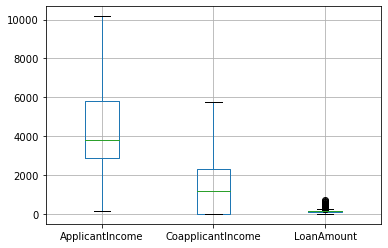

In [22]:
train.boxplot(column=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'])

<AxesSubplot:>

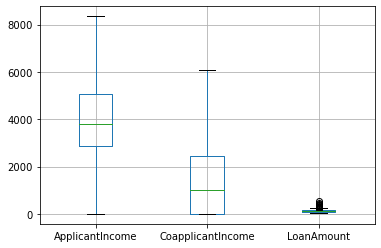

In [23]:
test.boxplot(column=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']);

## Bivariate Analysis

In [26]:
Dependents = pd.crosstab(train['Dependents'], train['Loan_Status'])
Dependents

Loan_Status,N,Y
Dependents,,
0,107,238
1,36,66
2,25,76
3+,18,33


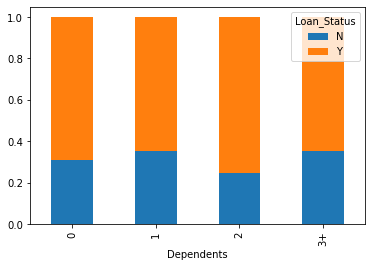

In [27]:
Dependents.div(Dependents.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True);

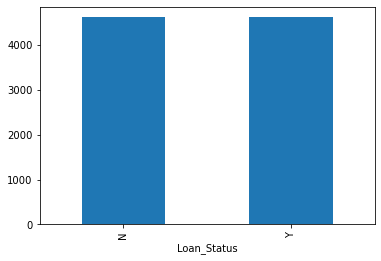

In [29]:
train.groupby('Loan_Status')['ApplicantIncome'].mean().plot.bar();

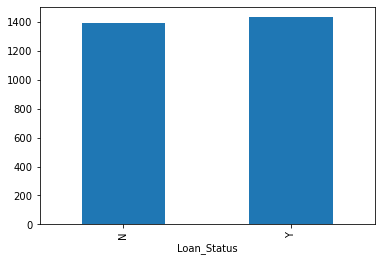

In [30]:
train.groupby('Loan_Status')['CoapplicantIncome'].mean().plot.bar();

In [24]:
train['Total_income']=train['ApplicantIncome']+train['CoapplicantIncome']

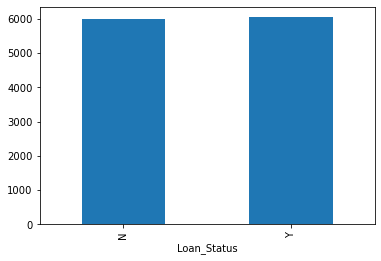

In [25]:
train.groupby('Loan_Status')['Total_income'].mean().plot.bar();

In [26]:
train=train.drop('Total_income', axis=1)

In [27]:
train.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [28]:
#fill missing values in categorical cols by mode
train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
train['Married'].fillna(train['Married'].mode()[0], inplace=True)
train['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True) 
train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
train['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0], inplace=True) 

In [29]:
# fill missing value in numerical col by median (as it has outliers)
train['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)

In [30]:
train.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [31]:
# likewise impute the missing values in test data
test['Gender'].fillna(test['Gender'].mode()[0], inplace=True)
test['Married'].fillna(test['Married'].mode()[0], inplace=True)
test['Dependents'].fillna(test['Dependents'].mode()[0], inplace=True)
test['Self_Employed'].fillna(test['Self_Employed'].mode()[0], inplace=True)
test['Credit_History'].fillna(test['Credit_History'].mode()[0], inplace=True)
test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].mode()[0], inplace=True)
test['LoanAmount'].fillna(test['LoanAmount'].median(), inplace=True)

In [32]:
test.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

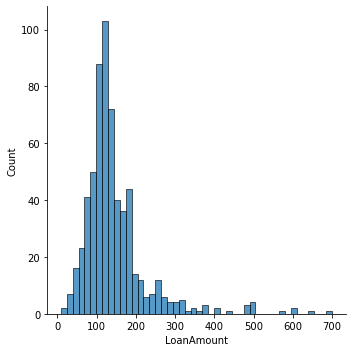

In [33]:
sns.displot(train['LoanAmount']); # Loan Amount distribution is right skewed

In [34]:
# taking log transformation to reduce the skewness
train['LoanAmount_log'] = np.log(train['LoanAmount'])

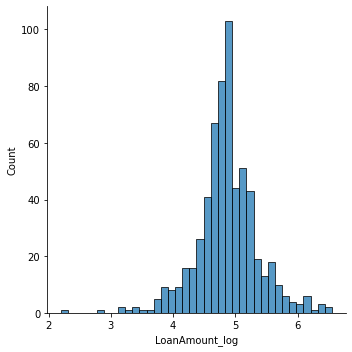

In [35]:
sns.displot(train['LoanAmount_log']);

In [36]:
test['LoanAmount_log'] = np.log(test['LoanAmount'])

In [37]:
train=train.drop('LoanAmount',1)
test=test.drop('LoanAmount',1)

## Data preparation

In [38]:
train['Dependents'].replace('3+', 3, inplace=True) # logistic regression cannot handle strings
test['Dependents'].replace('3+', 3, inplace=True)
train['Loan_Status'].replace(['N', 'Y'], [0,1], inplace=True)

In [39]:
# seggregating train dataset into X and y
X_train=train.drop('Loan_Status',1)
y_train=train.Loan_Status

In [40]:
# categorical to numerical

In [41]:
X_train=pd.get_dummies(X_train)
test=pd.get_dummies(test)
X_train

,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,Credit_History,LoanAmount_log,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_3,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,5849.0,0.0,360.0,1.0,4.852030,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1
1,4583.0,1508.0,360.0,1.0,4.852030,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0
2,3000.0,0.0,360.0,1.0,4.189655,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1
3,2583.0,2358.0,360.0,1.0,4.787492,0,1,0,1,0,1,0,0,0,1,1,0,0,0,1
4,6000.0,0.0,360.0,1.0,4.948760,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900.0,0.0,360.0,1.0,4.262680,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0
610,4106.0,0.0,180.0,1.0,3.688879,0,1,0,1,1,0,0,0,1,0,1,0,1,0,0
611,8072.0,240.0,360.0,1.0,5.533389,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1
612,7583.0,0.0,360.0,1.0,5.231109,0,1,0,1,0,0,0,1,1,0,1,0,0,0,1


## SMOTE for class imbalancing

In [42]:
X_train.shape

(614, 20)

In [43]:
from collections import Counter
counter=Counter(y_train)
counter

Counter({1: 422, 0: 192})

In [45]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=1)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)  
counter=Counter(y_train_res)
counter

Counter({1: 422, 0: 422})

## stratified k-fold CV (k=5)

In [47]:
result=[]
i=1
kf=StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
for train_index, test_index in kf.split(X_train_res,y_train_res):
    print('\n{} of kfold{}'.format(i,kf.n_splits))
    xtr,xvl=X_train_res.iloc[train_index], X_train_res.iloc[test_index]
    ytr,yvl=y_train_res.iloc[train_index], y_train_res.iloc[test_index]
    grid={'penalty':['l2', 'none'],'solver':['saga','sag','lbfgs', 'newton-cg'],'tol':[0.0001,0.00001]}
    model = LogisticRegression(max_iter=1000,verbose=True,n_jobs=-1, C=1.0, random_state=1)
    grid_search = GridSearchCV(estimator = model, param_grid = grid, scoring='accuracy')
    grid_search.fit(X_train_res, y_train_res)
    print(grid_search.best_params_,'\n')
    print(grid_search.best_estimator_)
    best_model = grid_search.best_estimator_
    # prediction on validation set
    pred_test=best_model.predict(xvl)
    # accuracy on validation set
    score=accuracy_score(yvl, pred_test)
    print('accuracy_score', score)
    result.append(score)
    i=i+1
statistics.mean(result) #mean validation accuray: of 5 accuracy values


1 of kfold5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

{'penalty': 'none', 'solver': 'newton-cg', 'tol': 0.0001} 

LogisticRegression(max_iter=1000, n_jobs=-1, penalty='none', random_state=1,
                   solver='newton-cg', verbose=True)
accuracy_score 0.8520710059171598

2 of kfold5


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

{'penalty': 'none', 'solver': 'newton-cg', 'tol': 0.0001} 

LogisticRegression(max_iter=1000, n_jobs=-1, penalty='none', random_state=1,
                   solver='newton-cg', verbose=True)
accuracy_score 0.863905325443787

3 of kfold5


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

{'penalty': 'none', 'solver': 'newton-cg', 'tol': 0.0001} 

LogisticRegression(max_iter=1000, n_jobs=-1, penalty='none', random_state=1,
                   solver='newton-cg', verbose=True)
accuracy_score 0.8520710059171598

4 of kfold5


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

{'penalty': 'none', 'solver': 'newton-cg', 'tol': 0.0001} 

LogisticRegression(max_iter=1000, n_jobs=-1, penalty='none', random_state=1,
                   solver='newton-cg', verbose=True)
accuracy_score 0.8579881656804734

5 of kfold5


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

{'penalty': 'none', 'solver': 'newton-cg', 'tol': 0.0001} 

LogisticRegression(max_iter=1000, n_jobs=-1, penalty='none', random_state=1,
                   solver='newton-cg', verbose=True)
accuracy_score 0.8571428571428571


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished


0.8566356720202875

In [49]:
# Prediction on the training set
ytrain_predict = best_model.predict(X_train_res)

In [51]:
## Classification report on the training data

#plot_confusion_matrix(best_model,X_train,y_train)
print(classification_report(y_train_res, ytrain_predict),'\n');

              precision    recall  f1-score   support

           0       0.98      0.73      0.84       422
           1       0.78      0.98      0.87       422

    accuracy                           0.86       844
   macro avg       0.88      0.86      0.85       844
weighted avg       0.88      0.86      0.85       844
 



In [52]:
# prediction on test set
pred_test=best_model.predict(test)

In [54]:
submission['Loan_ID']=test_original['Loan_ID']

NameError: name 'submission' is not defined

In [ ]:
# adding the prediction/results in loan_status col
submission['Loan_Status']=pred_test

In [ ]:
# we need prediction in Yes and No, so we need to convert 1 and 0 back to Yes and No
submission['Loan_Status'].replace(0, 'N', inplace=True)
submission['Loan_Status'].replace(1, 'Y', inplace=True)

In [ ]:
# converting the df back to csv file
pd.DataFrame(submission, columns=['Loan_ID', 'Loan_Status']).to_csv('submit_logistic_stratifiedkfoldcv.csv')